# Prototype code for solving Quantum Billiard problem

The Quantum Billiard problem describes a particle confined in a two-dimensional potential well with hard walls. The particle's wave function must satisfy the Schrödinger equation with boundary conditions that the wave function is zero at the walls.
The system is defined by the equation:
$$-\frac{\hbar^2}{2m} \nabla^2 \psi(x,y) = E \psi(x,y)$$
where $\psi(x,y)$ is the wave function, $E$ is the energy, and $\nabla^2$ is the Laplacian operatorm $\hbar$ is the reduced Planck's constant, and $m$ is the mass of the particle.

### Define the System
The domain for now is the unit square $[0,1] \times [0,1]$.
The analytical solution for the wave function in this case is:
$$\psi_{m,n}(x,y) = \sqrt{2} \sin(m \pi x) \sin(n \pi y)$$
where $m$ and $n$ are positive integers representing the quantum numbers of the system.
and Energy levels are given by:
$$E_{m,n} = \frac{\hbar^2 \pi^2}{2m} (m^2 + n^2)$$

In [1]:
import numpy as np
import dolfinx
from dolfinx import mesh, fem, io
import ufl
from petsc4py import PETSc
from slepc4py import SLEPc
from mpi4py import MPI
import pyvista

### 1. Define the Mesh and boundary conditions

In [4]:
# 1. Mesh and function space
n = 16
nx, ny = n,n
domain = mesh.create_unit_square(MPI.COMM_WORLD, nx, ny, mesh.CellType.triangle)
V = fem.functionspace(domain, ("Lagrange", 1))

# Boundary condition (Dirichlet homogeneous)
uD = fem.Function(V)
uD.interpolate(lambda x: np.zeros(x.shape[1]))

# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

### Plot the domain

In [5]:
import pyvista as pv
from dolfinx import plot

# pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)


plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

# Correct usage: show axis ticks and labels for X and Y
plotter.show_bounds(
    location='outer',
    show_xaxis=True,
    show_yaxis=True,
    show_zaxis=False,
    xlabel='X',
    ylabel='Y',
    font_size=10,
    color='black'
)

if not pv.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("fundamentals_mesh.png")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
ERROR:root:Unable to find a valid OpenGL 3.2 or later implementation. Please update your video card driver to the latest version. If you are using Mesa please make sure you have version 11.2 or later and make sure your driver in Mesa supports OpenGL 3.2 such as llvmpipe or openswr. If you are on windows and using Microsoft remote desktop note that it only supports OpenGL 3.2 with nvidia quadro cards. You can use other remoting software such as nomachine to avoid this issue.


: 

In [98]:
boundary_facets

array([  0,   3,   4,   6,  12,  14,  23,  25,  37,  39,  54,  56,  74,
        76,  97,  99, 123, 125, 152, 154, 184, 186, 219, 221, 257, 259,
       298, 300, 342, 344, 389, 391, 438, 439, 441, 484, 486, 526, 528,
       565, 567, 601, 603, 634, 636, 664, 666, 691, 693, 715, 717, 736,
       738, 754, 756, 769, 771, 781, 783, 790, 792, 796, 798, 799],
      dtype=int32)

### Define the variational form of the problem
Weak formulation of the problem is given by:
$$\int_{\Omega} \nabla \psi \cdot \nabla v \, dx = E \int_{\Omega} \psi v \, dx$$

In [99]:
# 3. Weak form: A u = E M u
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx  # Stiffness
m = ufl.inner(u, v) * ufl.dx                      # Mass

from dolfinx.fem.petsc import assemble_matrix
# assemble
A = assemble_matrix(fem.form(a), bcs=[bc])
A.assemble()
M = assemble_matrix(fem.form(m), bcs=[bc])
M.assemble()

### Solve the Eigenvalue problem

In [100]:
eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
eigensolver.setOperators(A, M)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)  # Generalized Hermitian
eigensolver.setWhichEigenpairs(SLEPc.EPS.Which.SMALLEST_REAL)
eigensolver.setFromOptions()
eigensolver.solve()

In [101]:
n_conv = eigensolver.getConverged()

for i in range(min(n_conv, 5)):
    eig_val = eigensolver.getEigenvalue(i)
    x = V.tabulate_dof_coordinates()

    # Allocate vector for eigenfunction
    r, _ = A.getVecs()
    eigensolver.getEigenvector(i, r)

    # Create Function in V and assign vector
    u_eig = fem.Function(V)
    u_eig.x.array[:] = r.getArray()

    if MPI.COMM_WORLD.rank == 0:
        print(f"Eigenvalue {i}: {eig_val}")




Eigenvalue 0: 1.000000000000414
Eigenvalue 1: 19.92978984221655


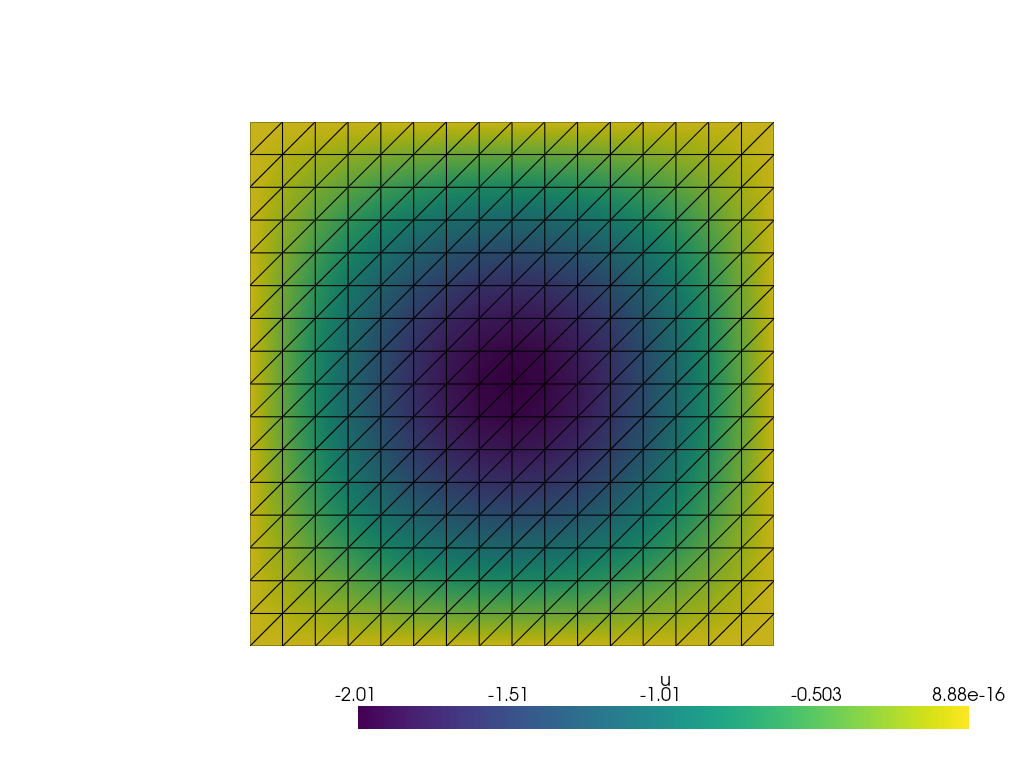

: 

In [ ]:
from dolfinx.plot import vtk_mesh
import pyvista as pv

if MPI.COMM_WORLD.rank == 0:
    # Build VTK-compatible mesh
    topology, cells, geometry = vtk_mesh(domain, domain.topology.dim)

    grid = pv.UnstructuredGrid(topology, cells, geometry)
    grid.point_data["u"] = u_eig.x.array.real  # use .imag if needed

    plotter = pv.Plotter()
    plotter.add_mesh(grid, show_edges=True, scalars="u", cmap="viridis")
    plotter.view_xy()
    plotter.show()


### Compute analytical solutions for comparison

In [ ]:
def get_eigvalues(n = 1, m = 1):
    # reduced planck constant
    hbar = 1.0
    mass = 1.0
    # Calculate eigenvalues using the formula for a 2D square potential well
    eig_value = (n**2 * np.pi**2 * hbar**2) / (2 * mass) * (n**2 + m**2)
    return eig_value

def get_eigfunctions(n, m, 
